In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../Task 1/')
from efficient_apriori import apriori
from improved_apriori import Improved_Apriori
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
data = pd.read_csv('Bakery.csv')
data = data[['tid', 'article']]
data = data.groupby('tid')['article'].apply(list)
data = data.to_dict()

In [3]:
# Step 2: Frequent Itemset Generation
# Use the apriori algorithm to generate frequent itemsets
apriori = Improved_Apriori(data, min_support=0.01, min_confidence=1)
frequent_itemsets = apriori.apriori()
frequent_itemsets

100%|██████████| 171/171 [00:00<00:00, 1491.77it/s]


{1: {('BAGUETTE',): 15292,
  ('BANETTE',): 15130,
  ('BANETTINE',): 2817,
  ('BOULE 200G',): 2691,
  ('BOULE 400G',): 4099,
  ('CAMPAGNE',): 3905,
  ('CEREAL BAGUETTE',): 4961,
  ('COMPLET',): 3140,
  ('COUPE',): 20470,
  ('CROISSANT',): 11508,
  ('FICELLE',): 2655,
  ('FORMULE SANDWICH',): 4202,
  ('MOISSON',): 3107,
  ('PAIN AU CHOCOLAT',): 10578,
  ('PAIN BANETTE',): 2727,
  ('SPECIAL BREAD',): 5195,
  ('TARTELETTE',): 2861,
  ('TRADITIONAL BAGUETTE',): 67689,
  ('VIK BREAD',): 3147}}

In [4]:
# Create a binary matrix
# Flatten the dictionary into a list of itemsets
from tqdm import tqdm
itemsets = [itemset for level in frequent_itemsets.values() for itemset in level.keys()]

# Transactions 
transactions = list(data.values())

binary_matrix = pd.DataFrame(0, index=range(len(transactions)), columns=itemsets)

# Fill in the binary matrix
for i, transaction in enumerate(tqdm(transactions)):
    for itemset in itemsets:
        if set(itemset).issubset(transaction):
            binary_matrix.at[i, itemset] = 1  # Use 'at' instead of 'loc' for scalar indexing

binary_matrix


100%|██████████| 234005/234005 [00:03<00:00, 77254.23it/s]


,"(BAGUETTE,)","(BANETTE,)","(BANETTINE,)","(BOULE 200G,)","(BOULE 400G,)","(CAMPAGNE,)","(CEREAL BAGUETTE,)","(COMPLET,)","(COUPE,)","(CROISSANT,)","(FICELLE,)","(FORMULE SANDWICH,)","(MOISSON,)","(PAIN AU CHOCOLAT,)","(PAIN BANETTE,)","(SPECIAL BREAD,)","(TARTELETTE,)","(TRADITIONAL BAGUETTE,)","(VIK BREAD,)"
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
234001,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
234002,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
234003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


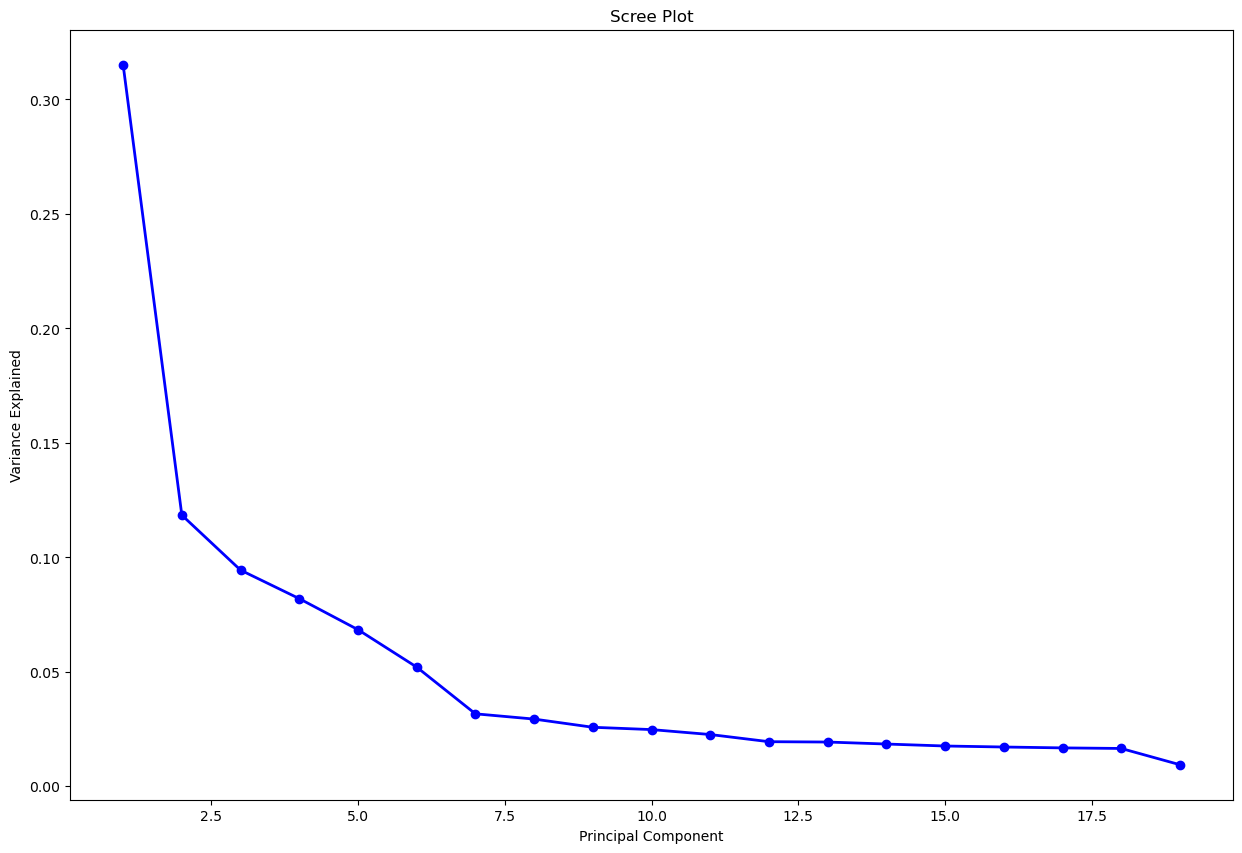

In [5]:
pca = PCA(random_state=24).fit(binary_matrix)
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(15,10))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [6]:
pca = PCA(n_components=4, random_state=42)
transformed_data = pca.fit_transform(binary_matrix)

In [7]:
def kmeans_elbow_method(data, max_k=10, figsize=(15, 8)):
    ssd = []
    silhouette_scores = []
    plt.figure(figsize=figsize)
    # Loop through different values of k
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        
        # Fit the k-means clustering model to the data
        kmeans.fit(data)
        
        # Calculate the sum of squared distances
        ssd.append(kmeans.inertia_)
        
        # Calculate the average silhouette score
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('Sum of squared distances', color='b')
    ax1.plot(range(2, max_k+1), ssd, 'bo-')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette score', color='r')
    ax2.plot(range(2, max_k+1), silhouette_scores, 'ro-')
    
    fig.tight_layout()
    plt.show()

/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

<Figure size 1500x800 with 0 Axes>

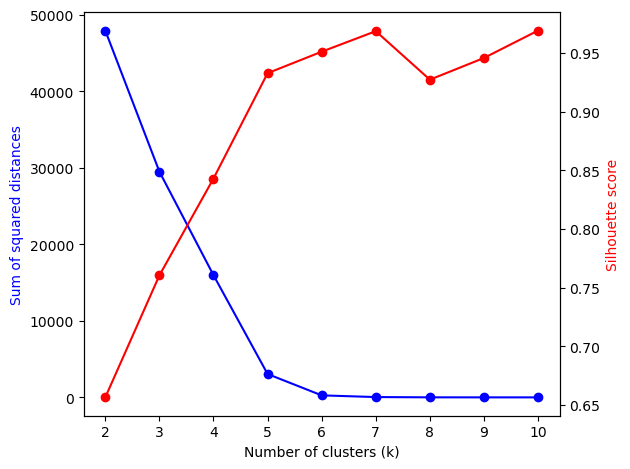

In [8]:
kmeans_elbow_method(transformed_data)

/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


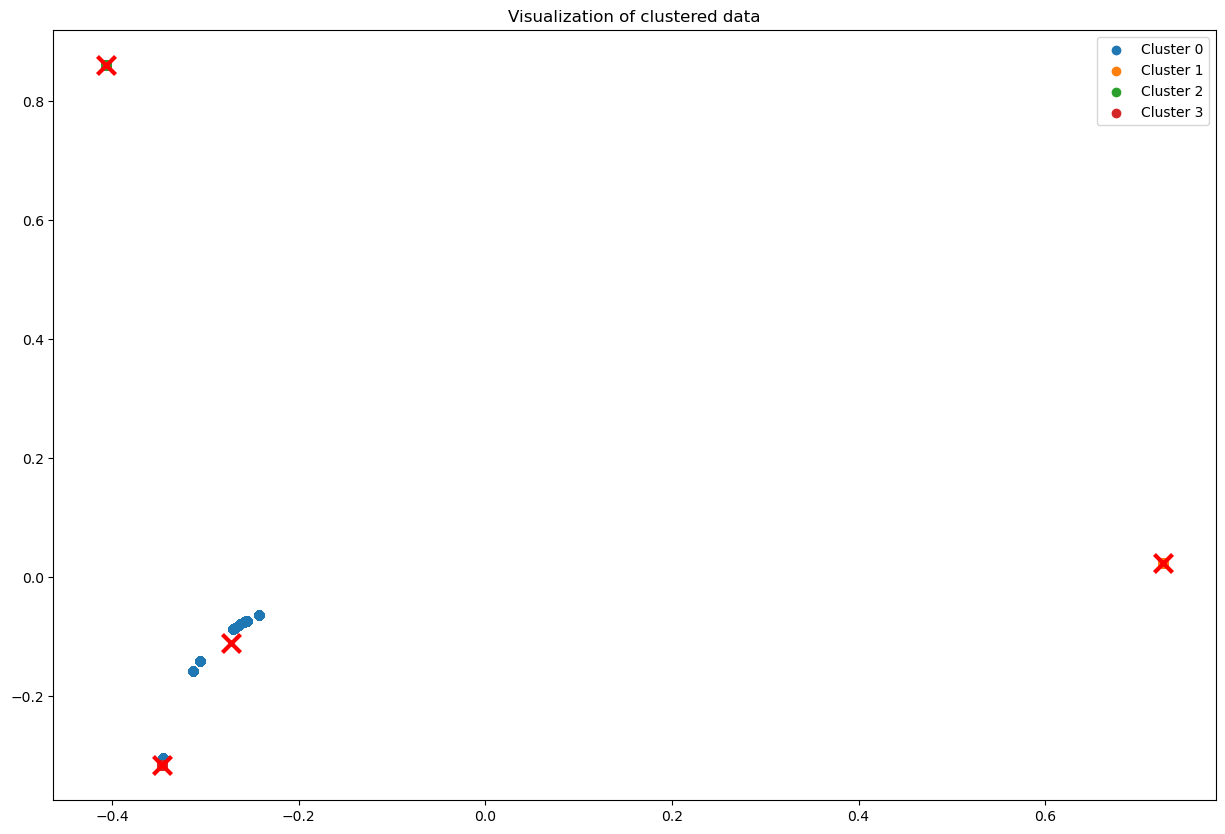

In [9]:
# Number of cluster for K-means to be 4 
k = 5
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(transformed_data)
cluster_labels = kmeans.labels_
kmeans_centroids = kmeans.cluster_centers_
#print(kmeans_centroids)
kmeans_silhouette = silhouette_score(transformed_data, cluster_labels)
plt.figure(figsize=(15,10))
for i in range(k):
    plt.scatter(transformed_data[cluster_labels == i, 0], transformed_data[cluster_labels == i, 1], label='Cluster '+str(i))
plt.legend()

# Plot the centroids

plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
plt.title('Visualization of clustered data')
plt.show()

In [10]:
binary_matrix['kmeans_cluster'] = cluster_labels

In [11]:
# Interpreting the itemset frequencies in each cluster
cluster_itemset_frequencies = binary_matrix.groupby('kmeans_cluster').sum()
cluster_itemset_frequencies

,"(BAGUETTE,)","(BANETTE,)","(BANETTINE,)","(BOULE 200G,)","(BOULE 400G,)","(CAMPAGNE,)","(CEREAL BAGUETTE,)","(COMPLET,)","(COUPE,)","(CROISSANT,)","(FICELLE,)","(FORMULE SANDWICH,)","(MOISSON,)","(PAIN AU CHOCOLAT,)","(PAIN BANETTE,)","(SPECIAL BREAD,)","(TARTELETTE,)","(TRADITIONAL BAGUETTE,)","(VIK BREAD,)"
kmeans_cluster,,,,,,,,,,,,,,,,,,,
0,0,15130,2817,2691,4099,3905,4961,3140,0,11508,2655,4202,3107,10578,2727,5195,2861,0,3147
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,67689,0
2,0,0,0,0,0,0,0,0,20470,0,0,0,0,0,0,0,0,0,0
3,15292,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
binary_matrix

,"(BAGUETTE,)","(BANETTE,)","(BANETTINE,)","(BOULE 200G,)","(BOULE 400G,)","(CAMPAGNE,)","(CEREAL BAGUETTE,)","(COMPLET,)","(COUPE,)","(CROISSANT,)","(FICELLE,)","(FORMULE SANDWICH,)","(MOISSON,)","(PAIN AU CHOCOLAT,)","(PAIN BANETTE,)","(SPECIAL BREAD,)","(TARTELETTE,)","(TRADITIONAL BAGUETTE,)","(VIK BREAD,)",kmeans_cluster
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
234001,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
234002,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
234003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [13]:
import ast
binary_matrix['bakery_level'] = binary_matrix.apply(lambda row: max([len(col) for col, val in row.items() if val == 1 and col != 'kmeans_cluster' and col!='bakery_level'], default=0), axis=1)
binary_matrix


,"(BAGUETTE,)","(BANETTE,)","(BANETTINE,)","(BOULE 200G,)","(BOULE 400G,)","(CAMPAGNE,)","(CEREAL BAGUETTE,)","(COMPLET,)","(COUPE,)","(CROISSANT,)",...,"(FORMULE SANDWICH,)","(MOISSON,)","(PAIN AU CHOCOLAT,)","(PAIN BANETTE,)","(SPECIAL BREAD,)","(TARTELETTE,)","(TRADITIONAL BAGUETTE,)","(VIK BREAD,)",kmeans_cluster,bakery_level
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234000,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2,1
234001,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
234002,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2,1
234003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1


In [14]:
cluster_bakery_level_counts = binary_matrix.groupby(['kmeans_cluster', 'bakery_level']).size()
cluster_bakery_level_counts

kmeans_cluster  bakery_level
0               0               47831
                1               82723
1               1               67689
2               1               20470
3               1               15292
dtype: int64

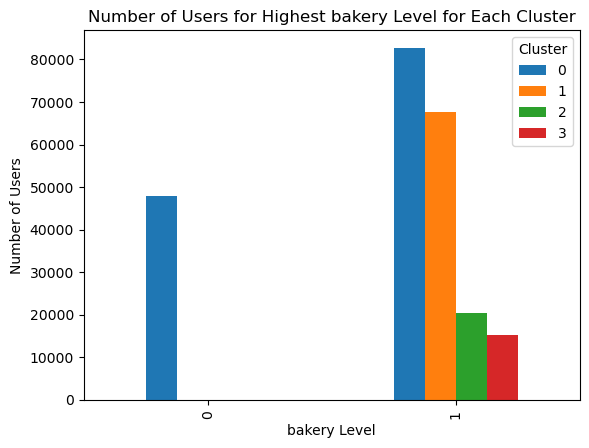

In [15]:
df_counts = cluster_bakery_level_counts.reset_index(name='counts')

df_pivot = df_counts.pivot(index='bakery_level', columns='kmeans_cluster', values='counts')

# Replace NaN values with 0
df_pivot.fillna(0, inplace=True)

# Create a bar plot
df_pivot.plot.bar()

# Add labels and title
plt.xlabel('bakery Level')
plt.ylabel('Number of Users')
plt.title('Number of Users for Highest bakery Level for Each Cluster')
plt.legend(title='Cluster')

# Show the plot
plt.show()

In [16]:
from sklearn import metrics

def evaluate_clustering(labels, data):
    # Calculate Silhouette score
    silhouette_score = metrics.silhouette_score(data, labels, metric='euclidean')

    # Calculate Davies-Bouldin Index
    davies_bouldin_index = metrics.davies_bouldin_score(data, labels)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_index = metrics.calinski_harabasz_score(data, labels)

    return silhouette_score, davies_bouldin_index, calinski_harabasz_index


Kmeans_silhouette, Kmeans_davies_bouldin, Kmeans_calinski_harabasz = evaluate_clustering(kmeans.labels_, transformed_data)

print(f'Kmeans Silhouette score: {Kmeans_silhouette}')
print(f'Kmeans Davies-Bouldin Index: {Kmeans_davies_bouldin}')
print(f'Kmeans Calinski-Harabasz Index: {Kmeans_calinski_harabasz}')

Kmeans Silhouette score: 0.8430681023768875
Kmeans Davies-Bouldin Index: 0.23556075507894406
Kmeans Calinski-Harabasz Index: 401948.01002372574


In [17]:
transformed_data

array([[-0.34671394, -0.31601252,  0.71684093, -0.46028553],
       [-0.30603683, -0.14077827, -0.01234069,  0.36526831],
       [-0.30603683, -0.14077827, -0.01234069,  0.36526831],
       ...,
       [-0.40598754,  0.86050571,  0.01089065, -0.13216536],
       [ 0.72628125,  0.02462073,  0.00109183, -0.01762008],
       [ 0.72628125,  0.02462073,  0.00109183, -0.01762008]])

In [18]:
# Normalize just with frequency
def normalize_frequent_itemsets(binary_matrix, itemset_frequencies):
    
    normalized_matrix = binary_matrix.drop(columns=['kmeans_cluster', 'bakery_level']).copy()

    for column in normalized_matrix.columns:
        # Find the level of the itemset (number of items in the itemset)
        level = len(column)

        # Get the frequency of the itemset from the dictionary
        frequency = itemset_frequencies[level][column]

        # Normalize the column by the itemset frequency
        normalized_matrix[column] = normalized_matrix[column] / frequency

    return normalized_matrix

#  A TF-IDF kindda method 
def tf_idf_normalize(binary_matrix,itemset_frequencies):

    TF_IDF_matrix = binary_matrix.drop(columns=['kmeans_cluster', 'bakery_level']).copy()
    # For each column in the binary matrix
    for column in TF_IDF_matrix.columns:
        level = len(column)

        # Get the frequency of the itemset from the dictionary
        frequency = itemset_frequencies[level][column]

        # Calculate IDF
        IDF = np.log(len(TF_IDF_matrix)/frequency)
        TF_IDF_matrix[column] = TF_IDF_matrix[column] * IDF


    return TF_IDF_matrix

In [19]:
normalized_matrix = normalize_frequent_itemsets(binary_matrix, frequent_itemsets)
normalized_matrix

,"(BAGUETTE,)","(BANETTE,)","(BANETTINE,)","(BOULE 200G,)","(BOULE 400G,)","(CAMPAGNE,)","(CEREAL BAGUETTE,)","(COMPLET,)","(COUPE,)","(CROISSANT,)","(FICELLE,)","(FORMULE SANDWICH,)","(MOISSON,)","(PAIN AU CHOCOLAT,)","(PAIN BANETTE,)","(SPECIAL BREAD,)","(TARTELETTE,)","(TRADITIONAL BAGUETTE,)","(VIK BREAD,)"
0,0.000065,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000095,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000095,0.0,0.0,0.0,0.000000,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000015,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000049,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
234001,0.000000,0.0,0.0,0.000372,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
234002,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000049,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
234003,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000015,0.0


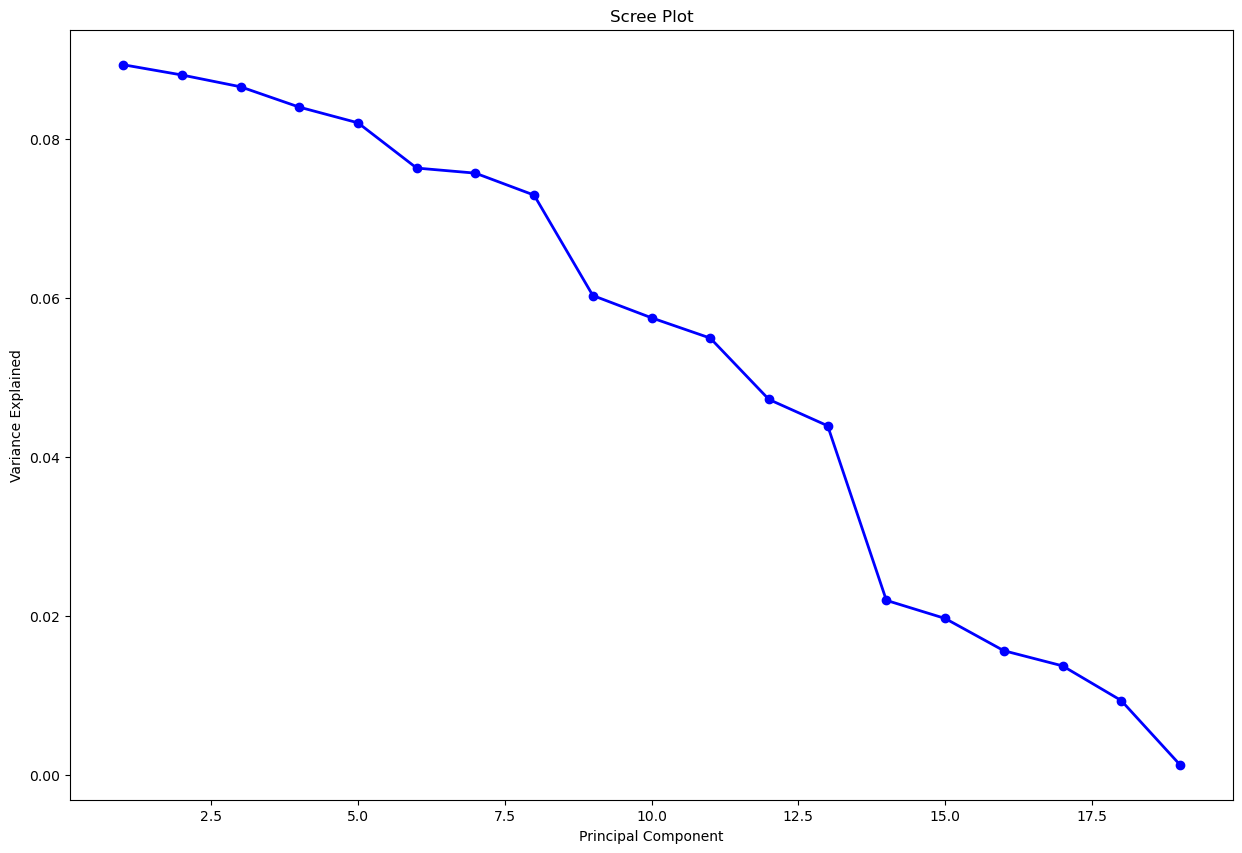

In [20]:
pca = PCA(random_state=24).fit(normalized_matrix)
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(15,10))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [21]:
pca = PCA(n_components=5, random_state=42)
transformed_normalized_data = pca.fit_transform(normalized_matrix)

/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

<Figure size 1500x800 with 0 Axes>

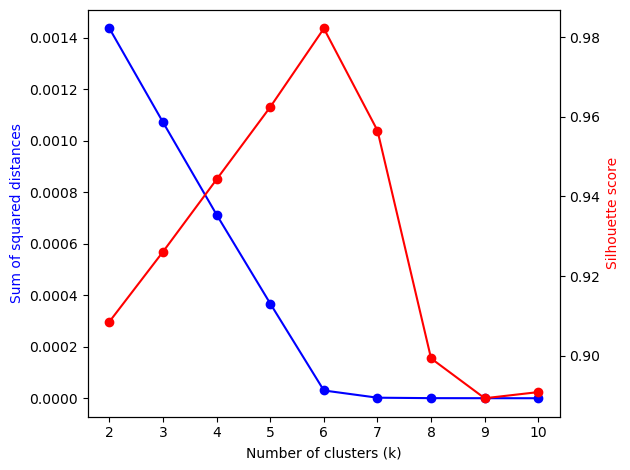

In [22]:
kmeans_elbow_method(transformed_normalized_data)

/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


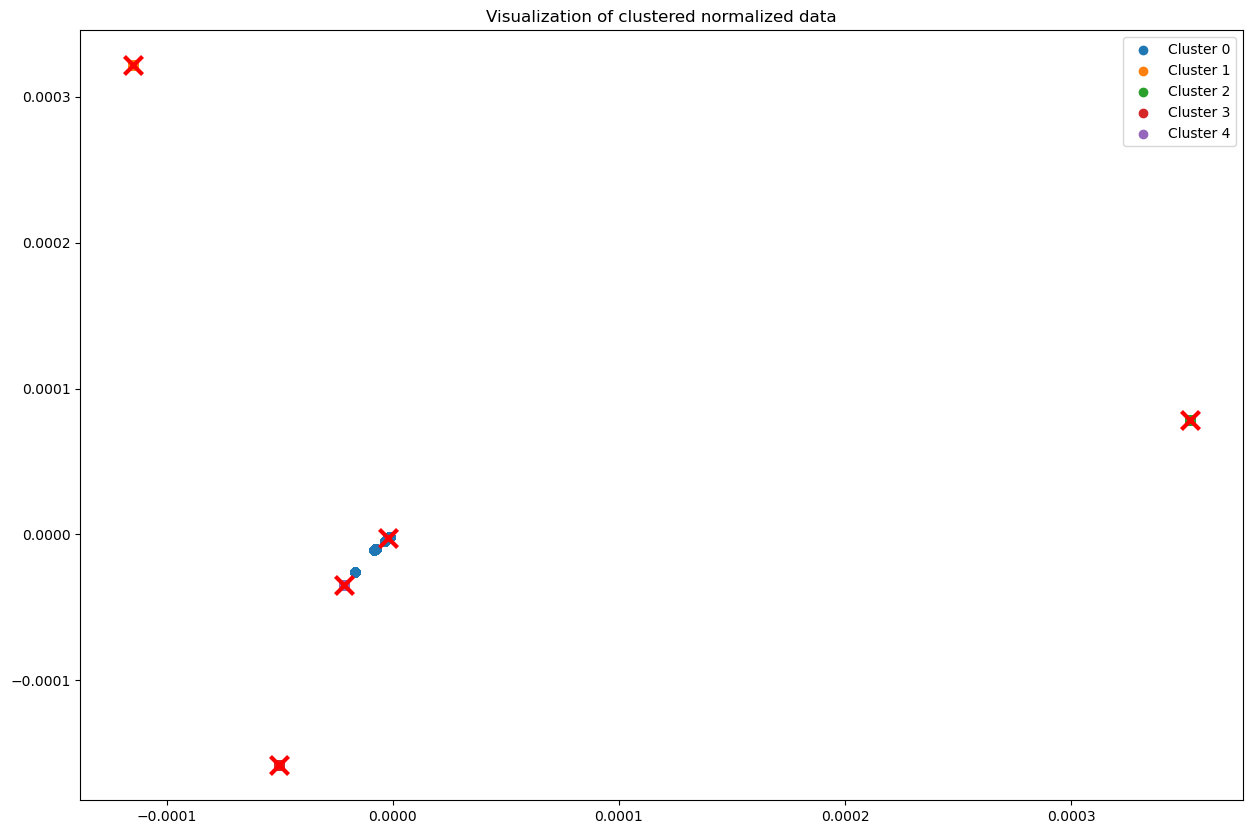

In [23]:
# Number of cluster for K-means to be 4 
k = 5
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(transformed_normalized_data)
cluster_labels = kmeans.labels_
kmeans_centroids = kmeans.cluster_centers_
#print(kmeans_centroids)
kmeans_silhouette = silhouette_score(transformed_normalized_data, cluster_labels)
plt.figure(figsize=(15,10))
for i in range(k):
    plt.scatter(transformed_normalized_data[cluster_labels == i, 0], transformed_normalized_data[cluster_labels == i, 1], label='Cluster '+str(i))
plt.legend()

# Plot the centroids
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
plt.title('Visualization of clustered normalized data')
plt.show()

In [24]:
Kmeans_Normalized_silhouette, Kmeans_Normalized_davies_bouldin, Kmeans_Normalized_calinski_harabasz = evaluate_clustering(kmeans.labels_, transformed_normalized_data)

print(f'Kmeans Normalized Silhouette score: {Kmeans_Normalized_silhouette}')
print(f'Kmeans Normalized Davies-Bouldin Index: {Kmeans_Normalized_davies_bouldin}')
print(f'Kmeans Normalized Calinski-Harabasz Index: {Kmeans_Normalized_calinski_harabasz}')

Kmeans Normalized Silhouette score: 0.9624865116917526
Kmeans Normalized Davies-Bouldin Index: 0.030301594216349377
Kmeans Normalized Calinski-Harabasz Index: 228923.5417102329


In [25]:
TF_IDF_matrix = tf_idf_normalize(binary_matrix, frequent_itemsets)
TF_IDF_matrix

,"(BAGUETTE,)","(BANETTE,)","(BANETTINE,)","(BOULE 200G,)","(BOULE 400G,)","(CAMPAGNE,)","(CEREAL BAGUETTE,)","(COMPLET,)","(COUPE,)","(CROISSANT,)","(FICELLE,)","(FORMULE SANDWICH,)","(MOISSON,)","(PAIN AU CHOCOLAT,)","(PAIN BANETTE,)","(SPECIAL BREAD,)","(TARTELETTE,)","(TRADITIONAL BAGUETTE,)","(VIK BREAD,)"
0,2.728013,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.096566,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.096566,0.0,0.0,0.0,0.000000,0.0
3,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.240419,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,2.436382,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
234001,0.000000,0.0,0.0,4.46543,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
234002,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,2.436382,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
234003,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.240419,0.0


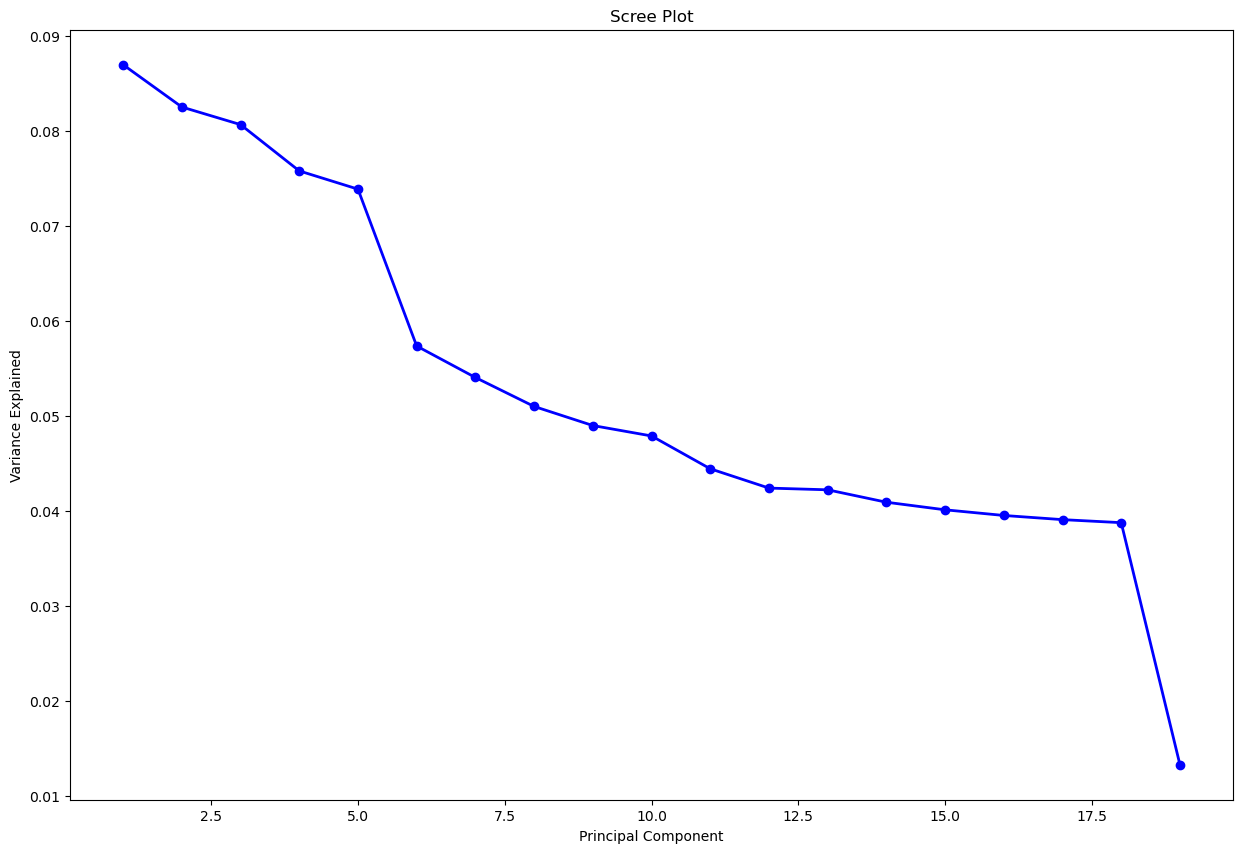

In [26]:
pca = PCA(random_state=24).fit(TF_IDF_matrix)
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(15,10))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [28]:
pca = PCA(n_components=5,random_state=42)
transformed_TF_IDF_data = pca.fit_transform(TF_IDF_matrix)

/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

<Figure size 1500x800 with 0 Axes>

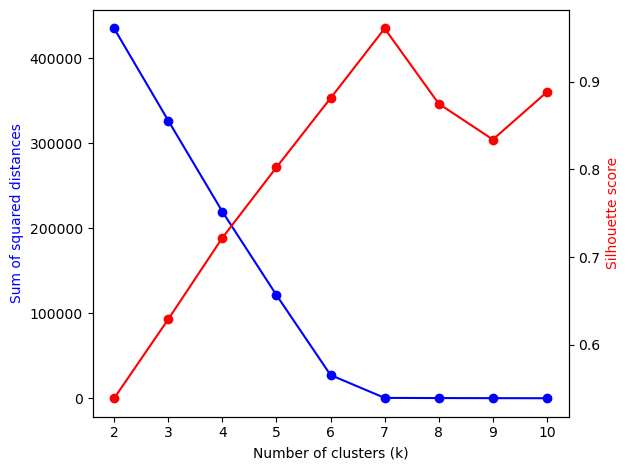

In [29]:
kmeans_elbow_method(transformed_TF_IDF_data)

/Users/sanskkriti/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


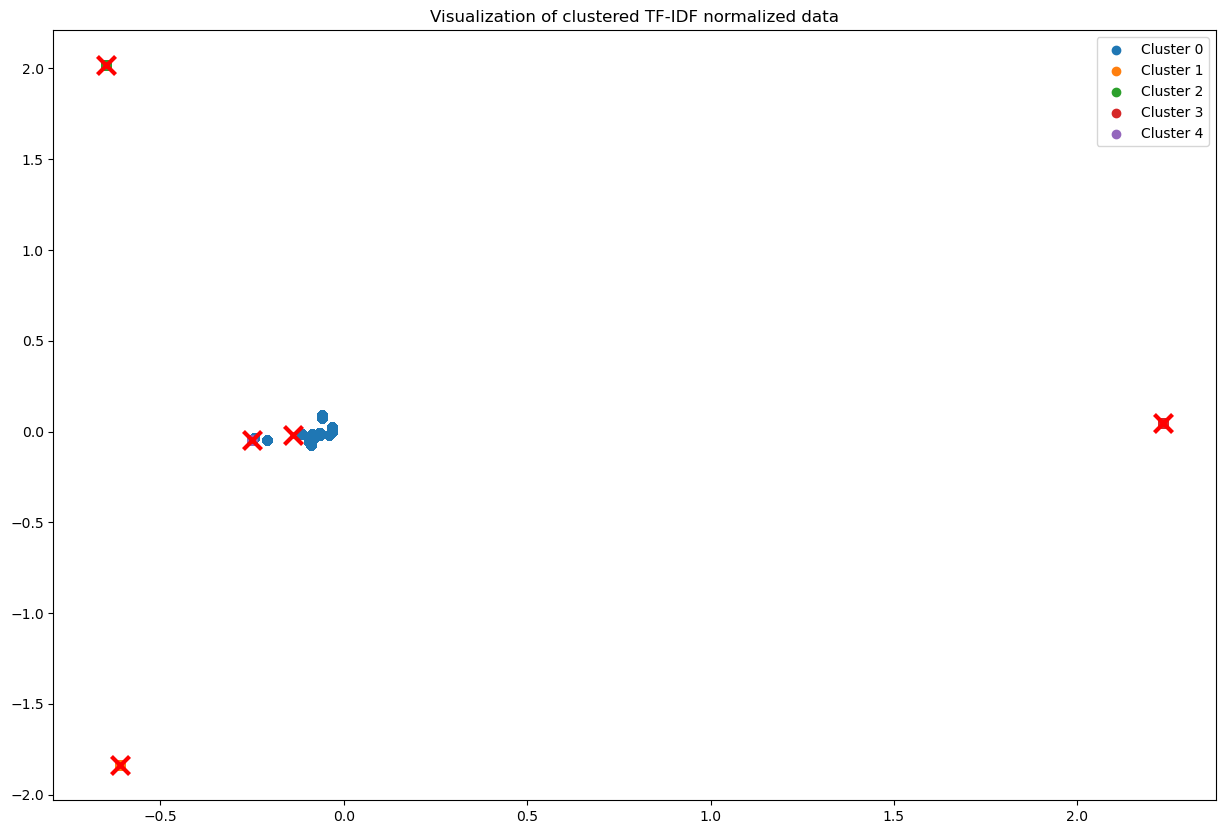

In [30]:
# Number of cluster for K-means to be 4 
k = 5
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(transformed_TF_IDF_data)
cluster_labels = kmeans.labels_
kmeans_centroids = kmeans.cluster_centers_
#print(kmeans_centroids)
kmeans_silhouette = silhouette_score(transformed_TF_IDF_data, cluster_labels)
plt.figure(figsize=(15,10))
for i in range(k):
    plt.scatter(transformed_TF_IDF_data[cluster_labels == i, 0], transformed_TF_IDF_data[cluster_labels == i, 1], label='Cluster '+str(i))
plt.legend()

# Plot the centroids
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
plt.title('Visualization of clustered TF-IDF normalized data')
plt.show()

In [31]:
Kmeans_TF_IDF_silhouette, Kmeans_TF_IDF_davies_bouldin, Kmeans_TF_IDF_calinski_harabasz = evaluate_clustering(kmeans.labels_, transformed_TF_IDF_data)

print(f'Kmeans TFIDF Silhouette score: {Kmeans_TF_IDF_silhouette}')
print(f'Kmeans TFIDF Davies-Bouldin Index: {Kmeans_TF_IDF_davies_bouldin}')
print(f'Kmeans TFIDF Calinski-Harabasz Index: {Kmeans_TF_IDF_calinski_harabasz}')

Kmeans TFIDF Silhouette score: 0.8023519274841581
Kmeans TFIDF Davies-Bouldin Index: 0.21758521829396166
Kmeans TFIDF Calinski-Harabasz Index: 206652.379765417
